# Monitoring data downloads from colhub portals

In [1]:
import pathlib
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
from IPython.display import Markdown as md

plt.rcParams["figure.figsize"] = (20,15)
plt.rcParams.update({'font.size': 22})

In [2]:
# show all rows, all columns
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)
pd.set_option('max_colwidth', None)

In [3]:
logsdir = pathlib.Path('../data')

In [4]:
def get_product_type(product):
    """ From a product title, get it's type """
    tipe = 'Unknown'
    try:
        if product[0:2] == 'S1':
            tipe = product.split('_')[2]
        elif product[0:2] == 'S2':
            tipe = product.split('_')[1]
            if not tipe.startswith('M'):
                tipe = 'Unknown'
        elif product[0:2] == 'S3':
            tmp = product.split('_')
            if tmp[1] == 'SL':
                tipe = 'SLSTR_L' + tmp[2]
            elif tmp[1] == 'SR':
                tipe = 'SRAL_L' + tmp[2]
            elif tmp[1] == 'OL':
                tipe = 'OLCI_L' + tmp[2]
            elif tmp[1] == 'SY':
                tipe = 'SYN_L' + tmp[2]
        elif product[0:2] == 'S5':
            tmp = product.split('_')
            if tmp[1] == 'OFFL':
                tipe = 'OFFL_' + tmp[2]
            elif tmp[1] == 'NRTI':
                tipe = 'NRTI_' + tmp[2]
        if 'DTERRENG' in product:
            tipe = tipe + '_DTERRENG'
    except TypeError:
        tipe = 'Unknown'
    return tipe

In [5]:
def get_data(file):
    data = pd.read_csv(file, header=None, names=['download_time', 'user', 'product', 'size', 'download_duration']\
                        , parse_dates=['download_time'], index_col='download_time')
    data['satellite'] = data['product'].apply(lambda x: x[0:2])
    data['product_type'] = data['product'].apply(get_product_type)
    return data[data['product_type'] != 'Unknown']

In this section the perfomance of the FrontEnds is analyzed, for both colhub.met.no and colhub-archive.met.no. The FEs perfomance is translated as user accesibility to the data which is one of the main goals for the project. 

## Portal: colhub.met.no

In [6]:
csvfile = logsdir / 'NBS_frontend-global_outputs.csv'
nbs_global = get_data(csvfile)

The first portal to analyze is colhub.met.no. The target of the analysis is to check the amount of data downloaded by users, but also the number of users accessing the datahub. Below the historical amount of data per day is represented.

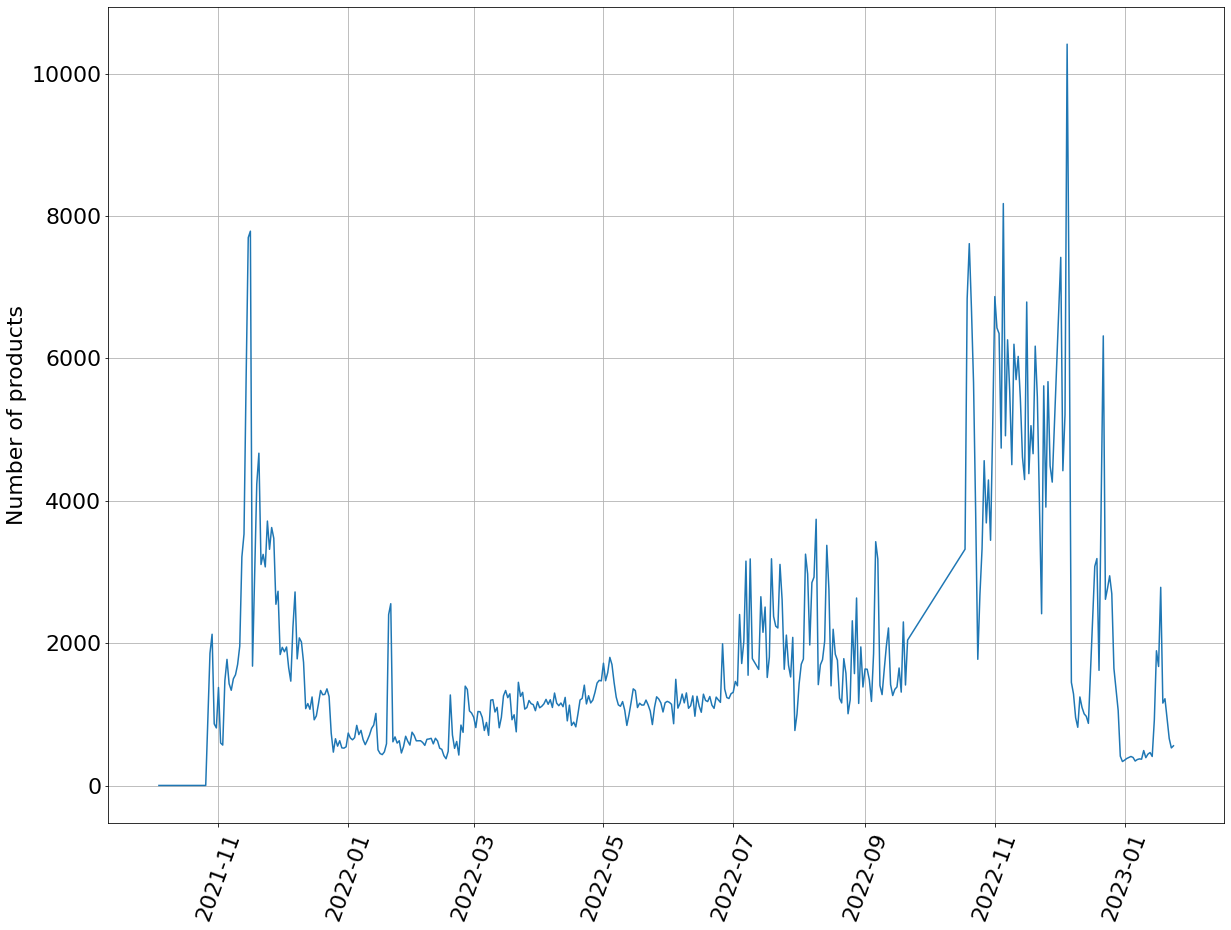

In [7]:
# Number of products downloaded per day
nbs_global.groupby(nbs_global.index.date).count()['product_type'].plot(ylabel='Number of products', rot=70)
plt.grid(True)

The same data is also represented below, with a difference. This time the data is not accounted by numer, but by volume. Although both graphs show similar trends, they are not exactly equal due to the variability in the ratio volume per product. For instance, the seasonality of optical products could have an impact in the total volume of products.

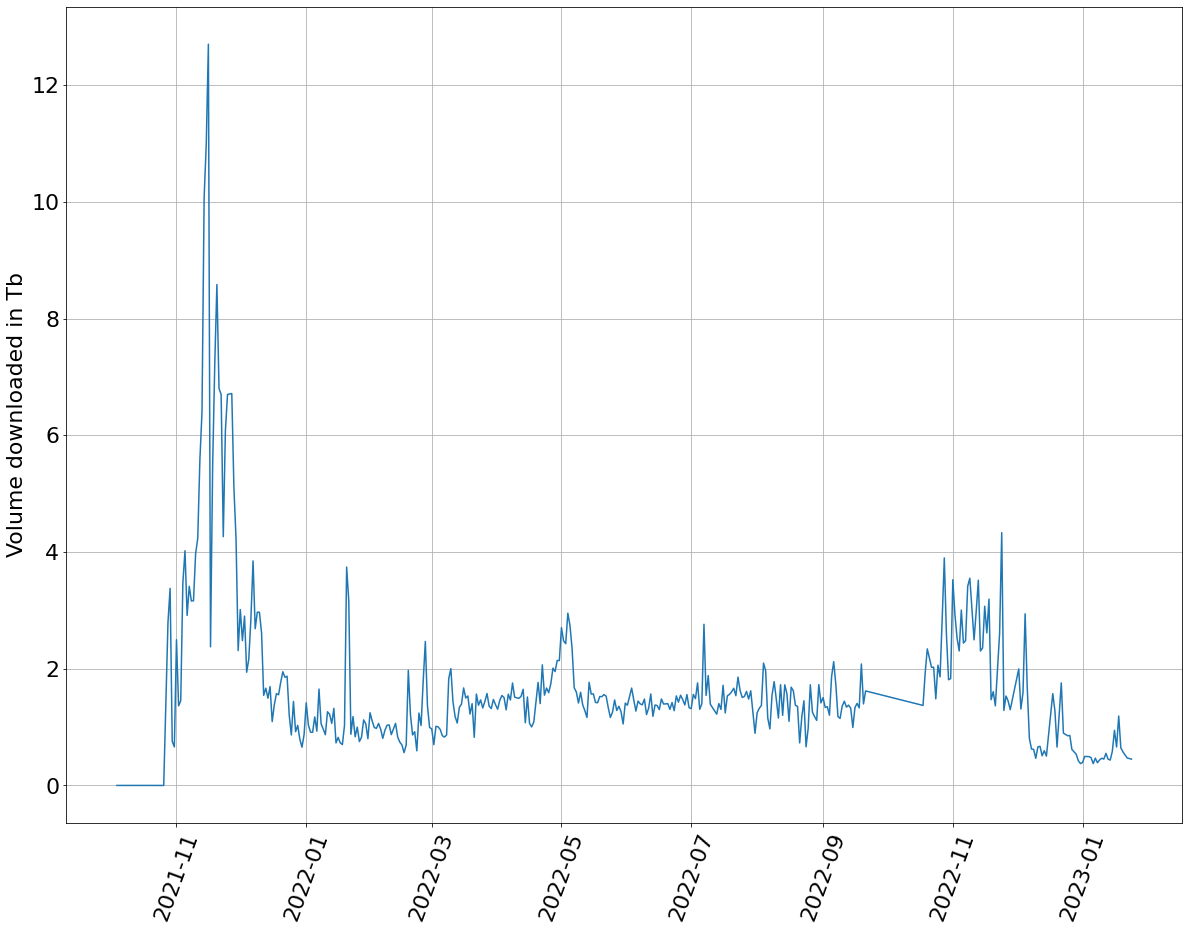

In [8]:
# Volume downloaded per day (in Tb)
total = nbs_global.groupby(nbs_global.index.date).sum()['size']/1024/1024/1024/1024
total.plot(ylabel='Volume downloaded in Tb', rot=70)
plt.grid(True)

The table below is also interesting. It shows the amount of products downloaded for each the different Sentinel products. As expected, S1 and S2 are the most used Sentinels. S3 is slightly used, while S5p is not used.

In [9]:
# Nb of products downloaded per satellite / product
col_table1 = nbs_global.groupby(['satellite', 'product_type']).size()
col_table1

satellite  product_type   
S1         GRDH               128914
           GRDM                48492
           OCN                 25762
           RAW                104550
           SLC                 27024
S2         MSIL1C             116015
           MSIL1C_DTERRENG      3100
           MSIL2A             313823
S3         OLCI_L1                73
           OLCI_L2                 3
           SLSTR_L1             3821
           SLSTR_L2                3
           SRAL_L1                16
           SRAL_L2                25
           SYN_L2                  5
S5         NRTI_L2              2043
           OFFL_L1B                2
dtype: int64

The following table shows the total downloaded volume of data in Tb per month. Here the seasonality of some Sentinel products can affect the final numbers.

In [10]:
# Monthly total retrieval in Tb
col_table2 = nbs_global.groupby([nbs_global.index.year, nbs_global.index.month]).sum()['size']/1024/1024/1024/1024
col_table2

download_time  download_time
2021           10                 7.588303
               11               158.654049
               12                57.675128
2022           1                 36.406545
               2                 29.798405
               3                 39.869718
               4                 46.768604
               5                 51.219186
               6                 42.277098
               7                 44.565096
               8                 42.852304
               9                 30.441359
               10                30.245704
               11                68.659549
               12                25.659783
2023           1                 11.861707
Name: size, dtype: float64

The number of users accessing and using the datahub is also important to be known. The plot below show the number of users per day. Some variability is represented in its numbers. Nevertheless, colhub.met.no is used by 15 to 20 users per day. 

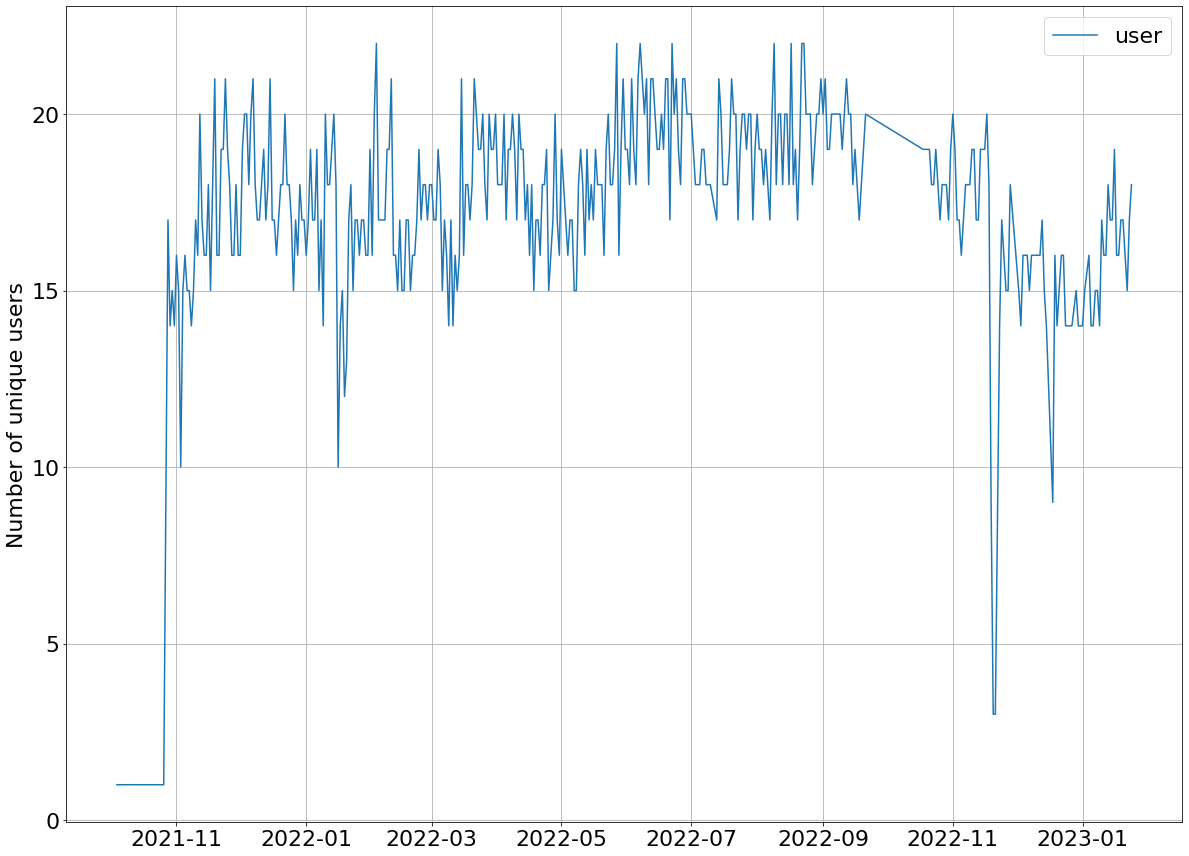

In [11]:
# Number of unique users that downloaded each day
nbs_global.groupby(nbs_global.index.date).agg({"user": "nunique"}).plot(ylabel='Number of unique users')
plt.grid(True)

## Portal: colhub-archive.met.no

In [12]:
csvfile = logsdir / 'NBS_frontend-AOI_outputs.csv'
nbs_AOI = get_data(csvfile)

Similar to colhub.met.no, here it is presented the performance of colhub-archive.met.no. First the number of products downloaded per day. As shown in the plot below, some days the number of products downloaded is null. This is a correct value which is not reflecting the performance of the FE. The archive is not as frequently accessed as colhub.met.no. Only those users looking for historical data will used this portal.

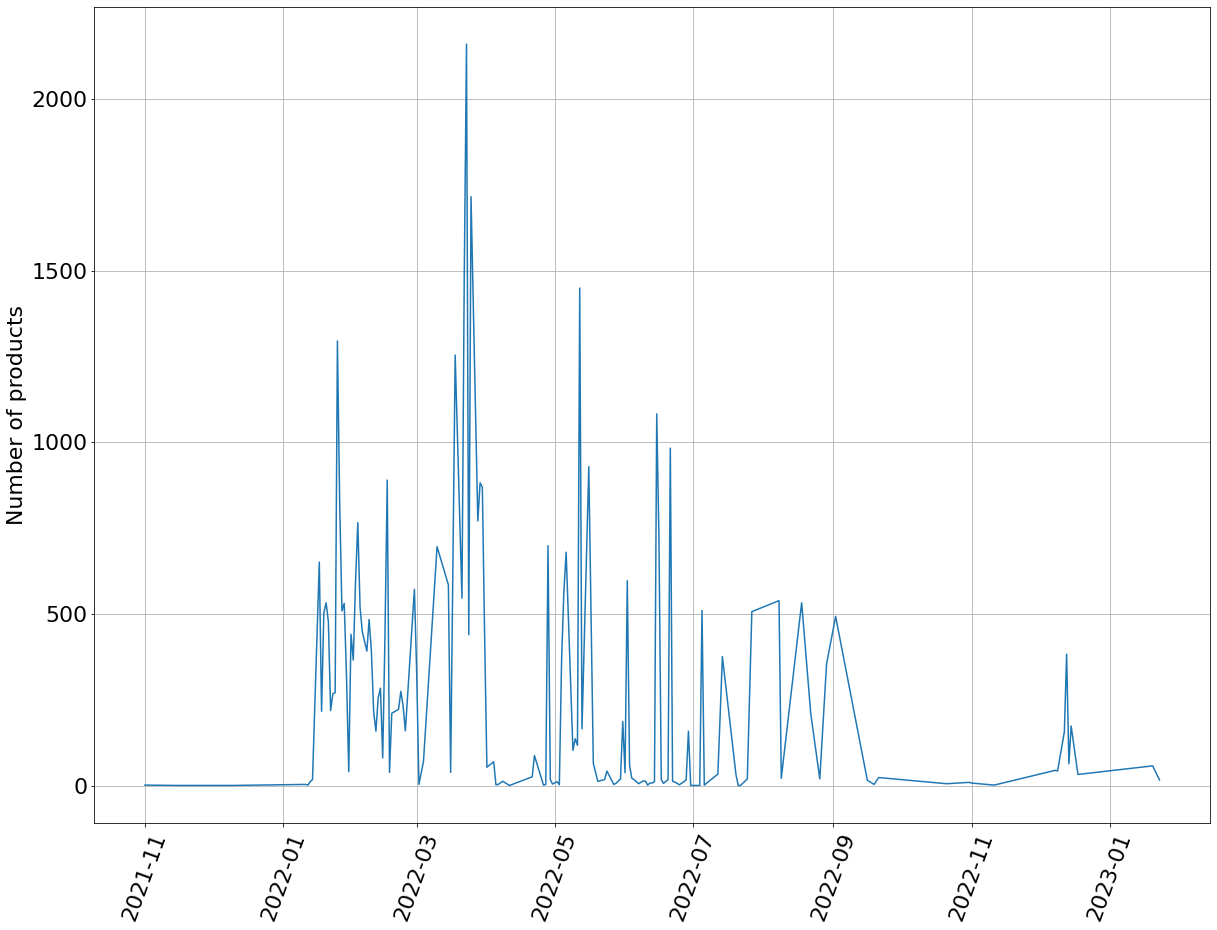

In [13]:
# Number of products downloaded per day
nbs_AOI.groupby(nbs_AOI.index.date).count()['product_type'].plot(ylabel='Number of products', rot=70)
plt.grid(True)

As explained and shown in the previous section, the total volume downloaded is also shown in the graphic below.  

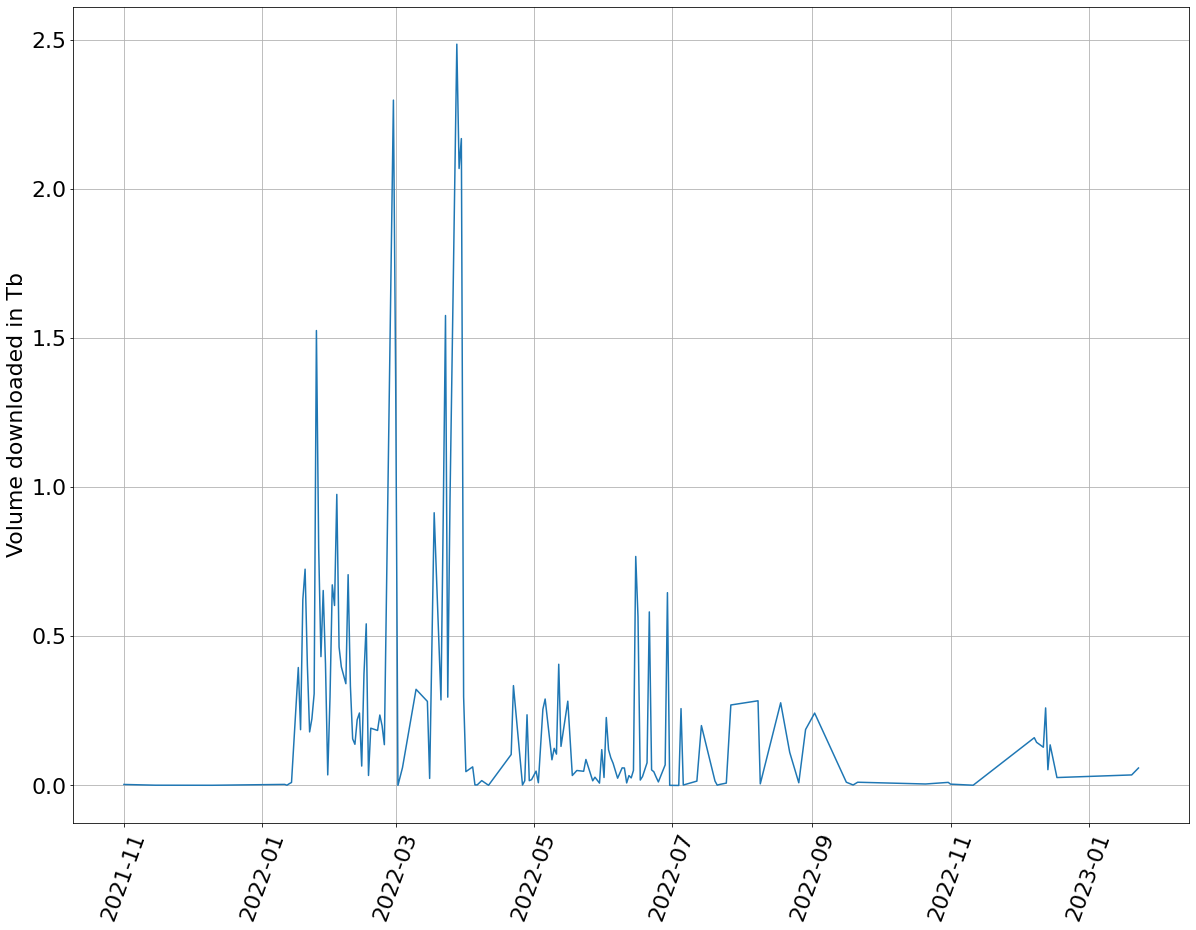

In [14]:
# Volume downloaded per day (in Tb)
total = nbs_AOI.groupby(nbs_AOI.index.date).sum()['size']/1024/1024/1024/1024
total.plot(ylabel='Volume downloaded in Tb', rot=70)
plt.grid(True)

It is still interesting to see the number of products downloaded per product type. As shown in the previous section, S1 and S2 still are the most popular Sentinels.

In [15]:
# Nb of products downloaded per satellite / product
col_table3 = nbs_AOI.groupby(['satellite', 'product_type']).size()
col_table3

satellite  product_type   
S1         GRDH               14805
           GRDM                4845
           RAW                    2
           SLC                 3207
S2         MSIL1C              6662
           MSIL1C_DTERRENG     2144
           MSIL2A             10018
S3         OLCI_L1                1
           SRAL_L1                4
           SRAL_L2              158
S5         OFFL_L2                1
dtype: int64

The table below shows the monthly retrieved volume of data in Tb.

In [16]:
# Monthly total retrieval in Tb
col_table4 = nbs_AOI.groupby([nbs_AOI.index.year, nbs_AOI.index.month_name()]).sum()['size']/1024/1024/1024/1024
col_table4

download_time  download_time
2021           December          0.000696
               November          0.005186
2022           April             0.858194
               August            0.874257
               December          0.908673
               February          9.514969
               January           7.210722
               July              0.771705
               June              3.787335
               March            13.999207
               May               2.258999
               November          0.005322
               October           0.015352
               September         0.266194
2023           January           0.093979
Name: size, dtype: float64

The last graphic show the number of users accessing and downloading data from the portal. Again, the discontinuity in numbers of users it is not a sign of the portal performance.

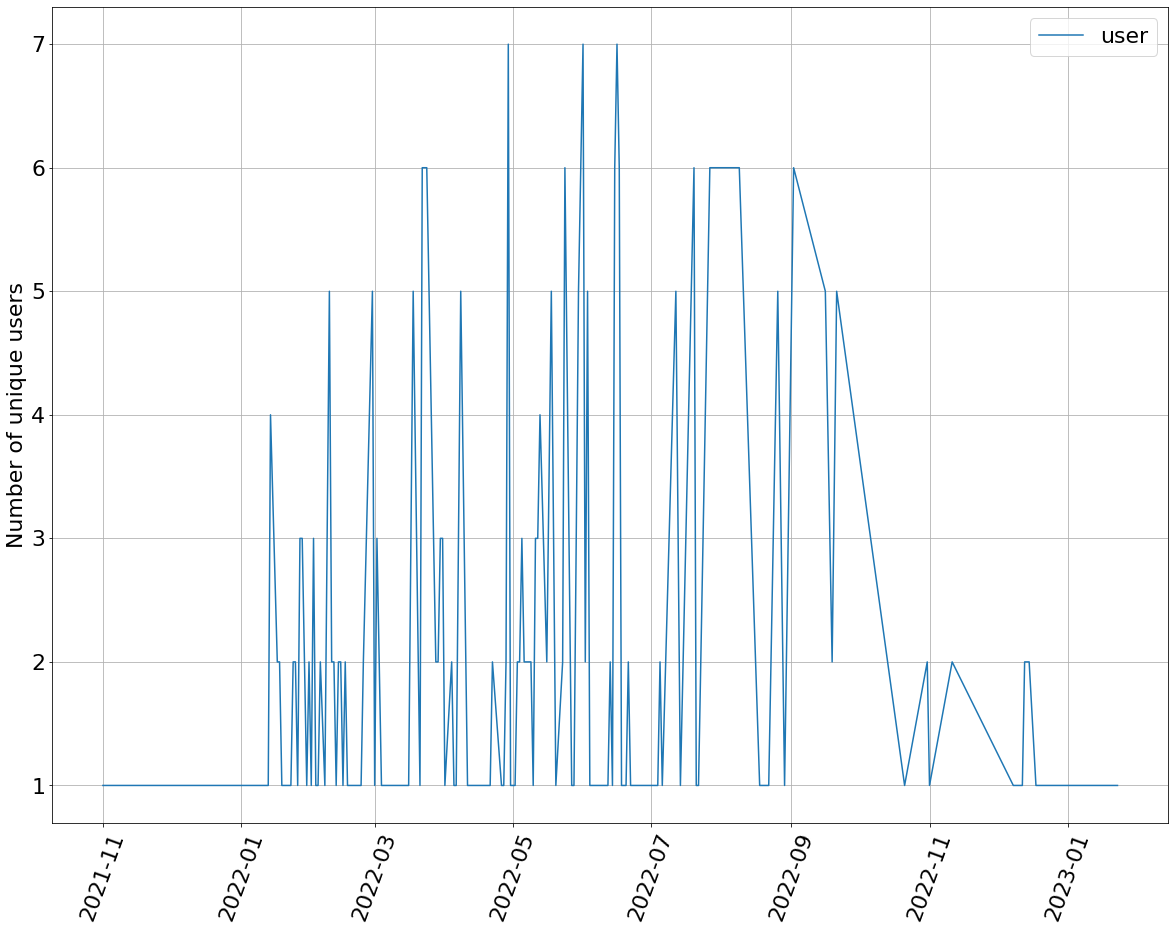

In [17]:
# Number of unique users that downloaded each day
nbs_AOI.groupby(nbs_AOI.index.date).agg({"user": "nunique"}).plot(ylabel='Number of unique users', rot=70)
plt.grid(True)